## Homework 7

We want to solve the linear system given by 
\begin{equation}
Ax = b,
\end{equation}
where $A$ is a non-singular $n\times n$ matrix. 

In this homework you will find the $LU$ factorization of the Matrix $A$, such that 
\begin{equation}
L\cdot U = A,
\end{equation}
where $L$ is lower triangular and $U$ is upper triangular. 

If the LU factors are known, then solving the linear system can be performed in two triangular solves:
\begin{equation}
Lp = b,
\end{equation}
and 
\begin{equation}
Ux = p.
\end{equation}


### Question 1: Linear Solver

#### LU factorization
Q1: Write a function that computes the LU factorization of a non-singular $n\times n$ matrix $A$. The input of your function will be

- A a non singular matrix

and the output will be a tuple $(L,U)$, such that $L\cdot U = A$, where 

- L is a lower triangular matrix
- U is an upper triangular matrix

Moreover, your function will raise an error if: 

- the matrix A is not square
- the matrix A is singular

You can use the built-in function det(), to check if you matrix is singular. 

In [1]:
function luFactorization(A)
    (n,m) = size(A)
    det(A) == 0 && error("Matrix is singular")
    n != m && error("matrix is not square")
    
    B = copy(A)
    # if you are using Julia v0.4 or above you need to
    # copy the elements of B
    
    # the factorization will be carried out in situ
    for i = 1:n-1
        B[i+1:n,i] = B[i+1:n,i]/B[i,i]
        B[i+1:n,i+1:n] = B[i+1:n,i+1:n] - B[i+1:n,i]*B[i,i+1:n]
    end
    
    # extracting the LU factors
    L = diagm(ones(n,1)[:],0) + tril(B,-1)
    U = triu(B,0)
    
    return (L,U)
end    

luFactorization (generic function with 1 method)

In [2]:
m = 100; 
A = rand(m,m) 
(L,U) = luFactorization(A);
maximum(abs(L*U- A))

1.7386092565629951e-13

#### Triangular solves

Q1b: Write a function that implements a upper triangular solve.
The input of your function will be 

- U an non-singular upper triangular matrix
- b a right-hand side

your function will output $x$, the solution to $Ux = b$

In [3]:
# write your triangular solver here
function backwardSubstitution(U,b)
    # input:    U upper triangular matrix 
    #           b vector
    # output:   x = U\b
    # checks for sizes
    (n,m) = size(U)
    (n != m) && error("Upper triangular matrix is not square \n")
    (n != size(b)[1]) && error("Dimension mismatch \n")
    
    # creating x and running the backward substitution
    x = zeros(b)
    x[n] = b[n]/U[n,n]
    for i = (n-1):-1:1
        x[i] = (b[i] - dot(U[i,i+1:end][:],x[i+1:end]))/U[i,i]
    end
    # returning x
    return x
end

backwardSubstitution (generic function with 1 method)

Q1c: Write a function that implements a lower triangular solve.
The input of your function will be 

- L an non-singular lower triangular matrix,
- b a right-hand side;

your function will output $x$, the solution to $Lx = b$

In [4]:
# write your triangular solver here
function forwardSubstitution(L,b)
    # input:    L lower triangular matrix 
    #           b vector
    # output:   x = L\b
    # checks for sizes
    (n,m) = size(L)
    (n != m) && error("Upper triangular matrix is not square \n")
    (n != size(b)[1]) && error("Dimension mismatch \n")
    
    # creating x and running the backward substitution
    x = zeros(b)
    x[1] = b[1]/L[1,1]
    for i = 1:n
        x[i] = (b[i] - dot(L[i,1:i-1][:],x[1:i-1]))/L[i,i]
    end
    # returning x
    return x
end

forwardSubstitution (generic function with 1 method)

#### Linear solvers

Q1d. Using your LU factorization and triangular solves, write a function that solves $Ax = b$

In [5]:
function linearSolve(A,b)
    # Lu factorization
    (L,U)  = luFactorization(A)
    # Ly = b
    y = forwardSubstitution(L,b)
    # Ux = y
    return backwardSubstitution(U,y)
end

linearSolve (generic function with 1 method)

In [6]:
m = 100; 
A = rand(m,m)
b = rand(m,1)
x = linearSolve(A,b)
println("residual is ", norm(A*x - b))

residual is 4.461253166811199e-11


### Question 2: Pivoted LU factorization

As for Gaussian Elimination, we can encounter small pivots that may have a negative impact on the accuracy of the factorization. In order to avoid that we use partial pivoting (row pivoting) to reorder the unknowns. 


#### PLU factorization
Q1: Write a function that computes the pivoted LU factorization of the non-singular $n\times n$ matrix $A$. The input of your function will be

- A a non singular matrix

and the output will be a tuple $(L,U,P)$, such that $L\cdot U = P\cdot A$, where 

- P a sparse permutation matrix 
- L is a lower triangular matrix
- U is an upper triangular matrix

Moreover, your function will raise an error if: 

- the matrix A is not square
- the matrix A is singular

You can use the built-in function det(), to check if you matrix is singular. 

In [7]:
function rowSwap!(A, i,j)
    # input:   A matrix
    #          i,j the row indexes to be swapped
    n = size(A)[1]
    # checking that i and j are within the permitted range
    (i > n || j > n ) && error("Index out of range in the rowSwap")
    # if the index are not the same
    if i != j 
        buffer = A[i,:]
        A[i,:] = A[j,:]
        A[j,:] = buffer
    end
end

rowSwap! (generic function with 1 method)

In [8]:
function luFactorizationPivoted(A)
    # checks
    (n,m) = size(A)
    det(A) == 0 && error("Matrix is singular")
    n!=m && error("matrix is not square")
    
    B = copy(A)
    # if you are using Julia v0.4 or above you need to
    # copy the elements of B
    P = speye(n,n);
    # the factorization will be carried out in situ
    for i = 1:n-1
        indj = indmax(abs(B[i:n,i])) + i - 1
        rowSwap!(B,i,indj)
        rowSwap!(P,i,indj)
        B[i+1:n,i] = B[i+1:n,i]/B[i,i]
        B[i+1:n,i+1:n] = B[i+1:n,i+1:n] - B[i+1:n,i]*B[i,i+1:n]
    end
    
    # extracting the LU factors
    L = diagm(ones(n,1)[:],0) + tril(B,-1)
    U = triu(B,0)
    
    return (L,U,P)
end    

luFactorizationPivoted (generic function with 1 method)

In [9]:
m = 100; 
A = rand(m,m)
(L,U,P) = luFactorizationPivoted(A);
maximum(abs(L*U- P*A))

2.1094237467877974e-15

Q2b. Using your triangular solvers, write a function that solves the system $Ax = b$ using a partially pivoted LU factorization. 

In [10]:
function linearSolvePivoted(A,b)
    # Lu factorization
    (L,U,P)  = luFactorizationPivoted(A)
    # Ly = b
    y = forwardSubstitution(L,P*b)
    # Ux = y
    return backwardSubstitution(U,y)
end

linearSolvePivoted (generic function with 1 method)

In [11]:
m = 100; 
A = rand(m,m) + m*eye(m)
b = rand(m,1)
x = linearSolve(A,b)
println("residual is ", norm(A*x - b))

residual is 2.0894506633436464e-15


### Question 3 (bonus): Solving the Helmholtz equation  (10 points)

The complexity of LU factorization is $\mathcal{O}(n^3)$ for a dense $n\times n$ matrix. 

Fortunately, most of the matrices arising from discretization of partial differential equations are not dense. 
In this case we will solve the 2D Helmholtz equation given by

\begin{equation}
\triangle u + \omega^2m u = f
\end{equation}
plus absorbing boundary conditions. <br>

The Helmholtz equation models waves propagating in a acoustic medium (like air or water). 
You will download the extra file Homework_7_extra.jl in the same folder as this ipybn, and you will run the snippet below. 

We will first define the number of points

In [12]:
Pkg.add("PyPlot")
using PyPlot
include("Homework_7_extra.jl")
nx = 200
ny = 200
N = nx*ny
h = 1/(nx-1)

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages
INFO: Loading help data...


0.005025125628140704

We will define the slowness $ m $ as a matrix full of ones, and we will call the function HelmholtzMatrix

In [13]:
m = ones(nx,nx)
# adding a reflector
m[round(Integer,nx/3):end, :]  = 2;
H = HelmholtzMatrix(m,nx,ny, 10, h,300, 2,2*pi*nx/10 );
println("Average number of nonzeros per row is :", nnz(H)/N)

Average number of nonzeros per row is :4.98


As you can see, the matrix is extremely sparse, it only contains around 5 non zeros per row. <br>
We will define a source, which in this case is a point source in the middle of the domain.

In [14]:
f = zeros(N,1)
f[nx*ny/2+ny/2] = 1/h^2


39601.0

Now we are ready to compute our solution. For that we will use the built-in LU factorization in Julia. (you may note that H is sparse, then by default julia will use UMFPACK to perform the factorization)

In [15]:
# perform the factorization
@time LU = lufact(H);
# solve the linear system
@time u = LU\f;

elapsed time: 0.526744944 seconds (13700092 bytes allocated)
elapsed time: 0.056273958 seconds (7075760 bytes allocated)


The solution is just a long vector, we need to reshape in order to plot it

In [16]:
U = reshape(u,nx,ny);

We can plot the solution using Gadfly, the solution is a complex number so we will plot the real and the imaginary part separately.

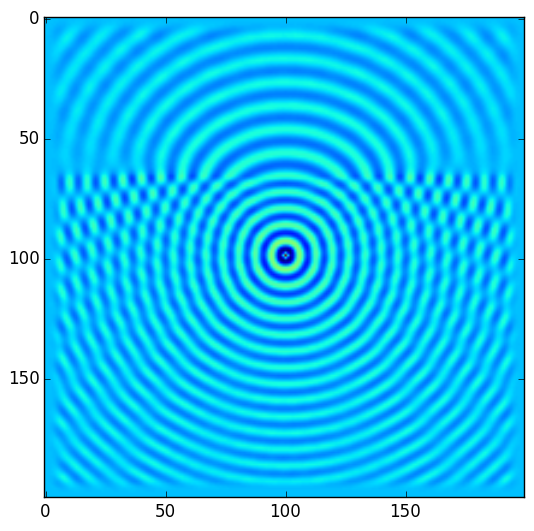

PyObject <matplotlib.image.AxesImage object at 0x126279190>

In [17]:
imshow(real(U))

Q3a. You will benchmark the time it takes to compute the LU factorization and to perform the solve with respect to the size of the problem $N$. What is the complexity of the factorization and the triangular solves in this case? How is that different from what you have seen in class? How can you explain the difference?

In [36]:
nSamples = 16
sizes = zeros(nSamples)
timesFac = zeros(nSamples)
timesSol = zeros(nSamples)

nx = 50
ny = 50

for i=1:nSamples
    sizes[i] = nx*ny
    h = 1/(nx-1)
    m = ones(nx,nx)
    # adding a reflector
    m[round(Integer,nx/3):end, :]  = 2;
    H = HelmholtzMatrix(m,nx,ny, 10, h,300, 2,2*pi*nx/10 );
    
    tic();
    LU = lufact(H);
    timesFac[i] = toc();
    # solve the linear system
    f = zeros(nx*ny,1)
    f[nx*ny/2+ny/2] = 1/h^2
    
    tic(); 
    u = LU\f;
    timesSol[i] = toc();
    nx+=50
    ny+=50
end


elapsed time: 0.021206051 seconds
elapsed time: 0.001456347 seconds
elapsed time: 0.066087595 seconds
elapsed time: 0.008043613 seconds
elapsed time: 0.152314072 seconds
elapsed time: 0.01726196 seconds
elapsed time: 0.309681144 seconds
elapsed time: 0.022441367 seconds
elapsed time: 0.51524804 seconds
elapsed time: 0.076688577 seconds
elapsed time: 0.76058783 seconds
elapsed time: 0.050888254 seconds
elapsed time: 1.074961938 seconds
elapsed time: 0.116512226 seconds
elapsed time: 1.512536019 seconds
elapsed time: 0.10373295 seconds
elapsed time: 2.021989097 seconds
elapsed time: 0.137354954 seconds
elapsed time: 2.495540922 seconds
elapsed time: 0.176166409 seconds
elapsed time: 3.144629736 seconds
elapsed time: 0.302917513 seconds
elapsed time: 3.843173779 seconds
elapsed time: 0.240901023 seconds
elapsed time: 4.734086339 seconds
elapsed time: 0.268574565 seconds
elapsed time: 5.79238048 seconds
elapsed time: 0.577505778 seconds
elapsed time: 6.552644838 seconds
elapsed time: 0.625

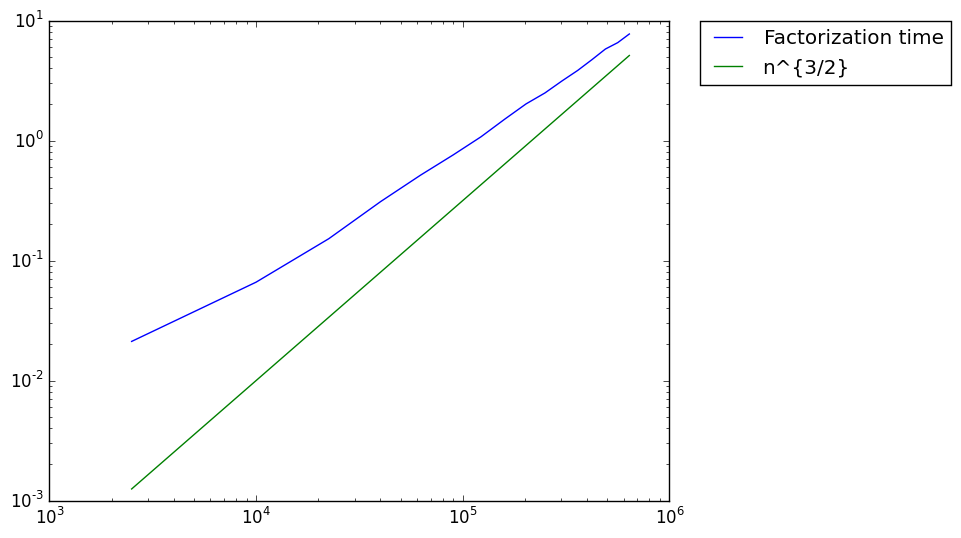

PyObject <matplotlib.legend.Legend object at 0x129e8d910>

In [58]:
#We will use Pyplot to plot in this case (you can use Gadfly)
plot(sizes, timesFac ,  label="Factorization time")
plot(sizes, 0.00000001*sizes.^(3/2),  label="n^{3/2}")
yscale("log")
xscale("log")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

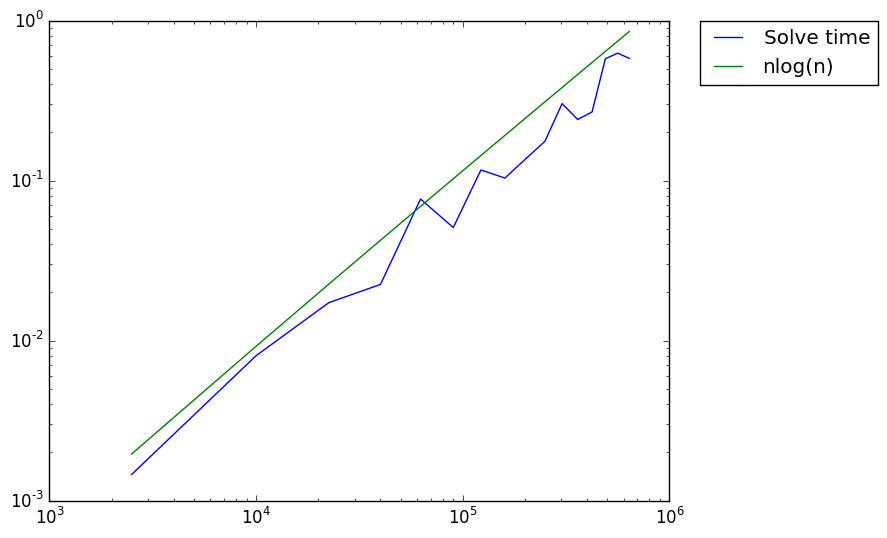

PyObject <matplotlib.legend.Legend object at 0x1299ecd10>

In [56]:
#We will use Pyplot to plot in this case (you can use Gadfly)
plot(sizes, timesSol , label="Solve time")
plot(sizes, 0.0000001*sizes.*log(sizes), label="nlog(n)")
yscale("log")
xscale("log")
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Hint: You may want to use the LU factorization algorithm you wrote (for a small $nx$) to obtain the LU factors. You can count the number of non-zeros of $L$ given by your algorithm and the number of nonzeros of $LU[:L]$, and compare them. You can use the function nnz(A) to obtain the number of nonzeros of a matrix.

If we used LU factorization naively we should expect that the complexity of $\mathcal{O}(N^3)$ for the factorization and $\mathcal{O}(N^2)$ for the solve. In the case of a sparse matrix, the total complexity will depend on the number of non-zeros introduced in the factorization step. 

If we make a small matrix 

In [71]:
nx = 25
ny = 25
N = nx*ny
h = 1/(nx-1)
m = ones(nx,nx)
# adding a reflector
m[round(Integer,nx/3):end, :]  = 2;
H = HelmholtzMatrix(m,nx,ny, 10, h,300, 2,2*pi*nx/10 );

We can look the sparsity pattern of H by typing 

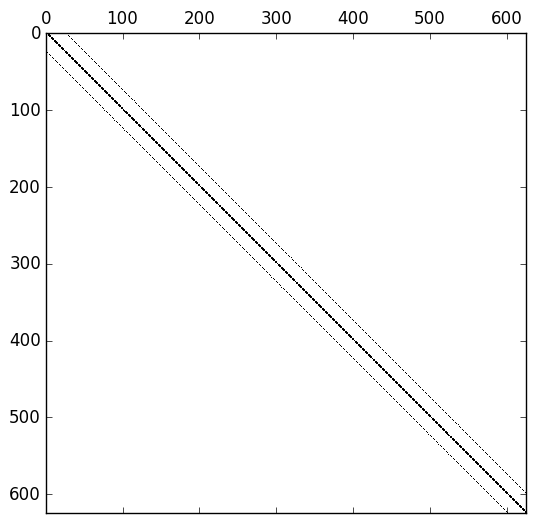

PyObject <matplotlib.image.AxesImage object at 0x129df8310>

In [72]:
spy(H)

We can observe that it is extremely sparse, it only has 5 non zeros per rown. <br>
If we use a naive LU factorization we have that 

In [75]:
(L,U) = lu(full(H));

we can take a look at the sparsity pattern of the LU factors.

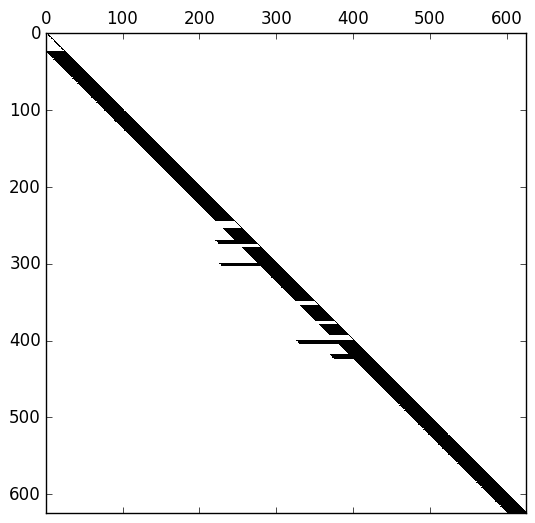

PyObject <matplotlib.image.AxesImage object at 0x129912790>

In [74]:
spy(L)

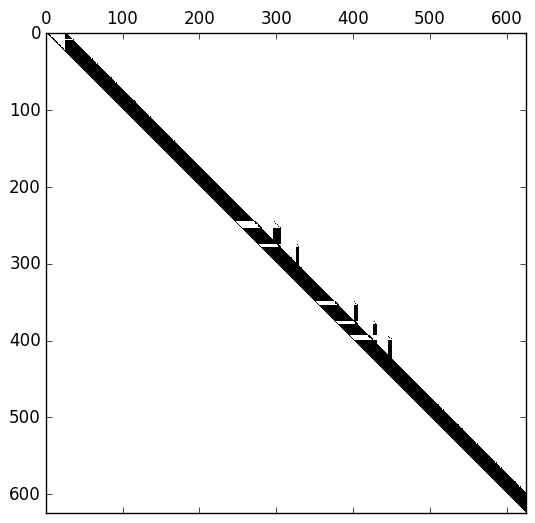

PyObject <matplotlib.image.AxesImage object at 0x11fe38090>

In [87]:
spy(U)

In [85]:
println("number of non zeros = ", countnz(L)+countnz(U))

number of non zeros = 31224


Now you have $\mathcal{O}(\sqrt{N})$  non zeros per row, then your LU factor are much less sparse than before. <br>

This issue is caused by the Gaussian eliminitation, you try to eliminate one column, but you introduce non-zeros somewhere else, process normally called fill-in.

If you perform a triangular solve using LU factors with this many non-zeros you would obtain a complexity $\mathcal{O}(N^{3/2})$, and we observe from the benchmark that the solves have a complexity $\mathcal{O}(N\log(N))$.

If we use UMFPACK to perform the operation 

In [77]:
 LU = lufact(H);

and we take a look at the sparsity of the LU factors

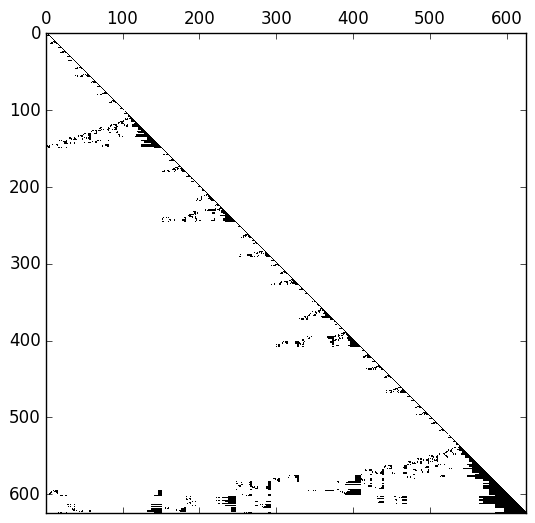

PyObject <matplotlib.image.AxesImage object at 0x124b5f990>

In [81]:
spy(LU[:L])

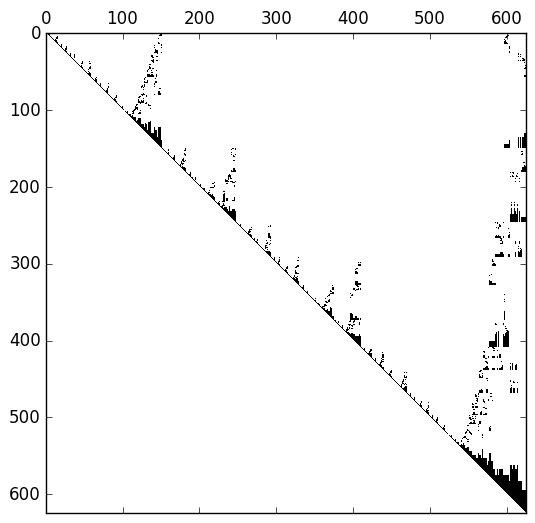

PyObject <matplotlib.image.AxesImage object at 0x12399fe50>

In [82]:
spy(LU[:U])

In [86]:
println("number of non zeros = ", countnz(LU[:L])+countnz(LU[:U]))

number of non zeros = 12736


You can see that they are much sparse than LU factors resulting from a naive LU factorization.

This is because, UMFPACK uses a reordering of the unknowns, that results in a much lower fill-in. This reordering is called nested dissection. https://en.wikipedia.org/wiki/Nested_dissection.

If we use nested dissection with a sparse matrix like $H$ it is known that the complexities are $\mathcal{O}(N^{3/2})$ for the factorization and  $\mathcal{O}(N\log{N})$ for each solve. 

The graph for the solving time corroborates the theoretical scaling; however, the graph for factorization time seems to have a lower complexity than the theory predicts. This is normal because we are not dealing with problems big enough, and we need to take in account the time of memory access. In the case of the LU factorization you can reuse the data in the cache to perform several operations, before having to empty the cache. 

If we were to continue the benchmarking for problems bigger and bigger we would obtain the correct scaling. 

### Note
As a general rule for dealing with sparse matrices, is that sparse is good, and if your non-zeros are concentrated around the diagonal, then it is even better.

### Question 4 (bonus): Full Pivoted LU Decomposition (10 points)

Q4a. Write a function that implements the fully pivoted LU factorization of the non-singular $n\times n$ matrix $A$. The input of your function will be

- A a non singular matrix

and the output will be a tuple $(L,U,P,Q)$, such that $L\cdot U = P\cdot A \cdot Q$, where 

- P a sparse permutation matrix 
- Q a sparse permutation matrix
- L is a lower triangular matrix
- U is an upper triangular matrix

Moreover, your function will raise an error if: 

- the matrix A is not square
- the matrix A is singular

You can use the built-in function det(), to check if you matrix is singular. 




In [47]:
function colSwap!(A, i,j)
    # input:   A matrix
    #          i,j the row indexes to be swapped
    n = size(A)[1]
    # checking that i and j are within the permitted range
    (i > n || j > n ) && error("Index out of range in the rowSwap")
    # if the index are not the same
    if i != j 
        buffer = A[:,i]
        A[:,i] = A[:,j]
        A[:,j] = buffer
    end
end

colSwap! (generic function with 1 method)

In [48]:
function findMaxIJ(A)
    (n,m) = size(A)
    idxMax = indmax(abs(A)[:])
    indi = mod(idxMax-1,n)+1
    indj = round(Integer, floor((idxMax-1)/n)) + 1
    return (indi,indj)
end

findMaxIJ (generic function with 1 method)

In [49]:
A = [1. 8. 9. ; 2. 4. 5. ; 1. 18. 7.]
println(A)
findMaxIJ(A)

[1.0 8.0 9.0
 2.0 4.0 5.0
 1.0 18.0 7.0]


(3,2)

In [55]:
function luFactorizationFullPivoted(A)
    # checks
     # checks
    (n,m) = size(A)
    det(A) == 0 && error("Matrix is singular")
    n!=m && error("matrix is not square")
    
    B = copy(A)
    # if you are using Julia v0.4 or above you need to
    # copy the elements of B
    P = speye(n,n);
    Q = speye(n,n);
    # the factorization will be carried out in situ
    for i = 1:n-1
        # getting the indices of the maximum index
        (indi, indj) = findMaxIJ(B[i:n,i:n])
        # adding the correct shift in the indices
        (indi, indj) = (indi +i-1, indj+i-1)
        # performing the swapping
        rowSwap!(B,i,indi)
        rowSwap!(P,i,indi)
        colSwap!(B,i,indj)
        colSwap!(Q,i,indj)
        # Gaussian elimination 
        B[i+1:n,i] = B[i+1:n,i]/B[i,i]
        B[i+1:n,i+1:n] = B[i+1:n,i+1:n] - B[i+1:n,i]*B[i,i+1:n]
    end
    
    # extracting the LU factors
    L = diagm(ones(n,1)[:],0) + tril(B,-1)
    U = triu(B,0)
    
    return (L,U,P,Q)
end    

luFactorizationFullPivoted (generic function with 1 method)

In [65]:
# testing the different LU factorization
# algorithm
m = 200; 
A = rand(m,m)
(L,U) = luFactorization(A);
println(maximum(abs(L*U- A)))
(L,U,P) = luFactorizationPivoted(A);
println(maximum(abs(L*U- P*A)))
(L,U,P,Q) = luFactorizationFullPivoted(A);
println(maximum(abs(L*U- P*A*Q)))

6.959988141375106e-13
3.9968028886505635e-15
2.55351295663786e-15
